# Exploring Complex Regularization Techniques on Image Classification

In [16]:
# packages required for new environment
# ! pip install pandas
# ! pip install nltk
# ! pip install datasets
# ! pip install tqdm
# ! pip install ipywidgets
# ! pip install Pillow

In [1]:
#Libraries
import pandas as pd
import numpy as np
import datasets
import nltk
import os
import random
# from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf


# import tensorflow_datasets as tfds
import tensorflow as tf  # For tf.data
import keras
import csv
from keras import layers
from tensorflow.keras import regularizers
from keras.applications import EfficientNetB0

# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 64
BATCH_SIZE = 64
NUM_CLASSES = 15
EPOCHS = 25
LR = 1e-3

## Dataset 1 - Tiny Imagenet

In [2]:
# 1. tiny-imagenet
#   (a) Dataset Summary - Tiny ImageNet contains 100,000+ images of 200 classes (500 for each class) downsized to 64×64 colored images. Each class has 500 training images, 50 validation images, and 50 test images.
#   (b) Data Feature Dimensions -
#       i. Image: A PIL.Image.Image object containing the image.
#       ii. Label: an int classification label. -1 for the test set as the labels are missing. Check classes.py for the map of numbers and labels.

# Stanford Tiny ImageNet Data Retrieval

This documentation outlines the process of retrieving data directly from the Stanford data source for the Tiny ImageNet dataset.

## Data Retrieval Steps

1. **Download the Dataset**: 
    - The Tiny ImageNet dataset can be downloaded directly from the Stanford data source using the following command:
    ```bash
    !wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
    ```
2. **Unzip the Dataset**:
    - Once the dataset is downloaded, it needs to be unzipped. This can be done using the following command:
    ```bash
    !unzip -qq 'tiny-imagenet-200.zip'
    ```
3. **Set Data Directory**:
    - Define the directory where the dataset is located. By default, the images come in shapes of [3, 64, 64].
    ```python
    DATA_DIR = 'tiny-imagenet-200'
    ```
4. **Define Training and Validation Paths**:
    - Specify the paths for the training and validation data directories within the downloaded dataset.
    ```python
    TRAIN_DIR = os.path.join(DATA_DIR, 'train')
    VALID_DIR = os.path.join(DATA_DIR, 'val')
    ```

In [3]:
# Retrieve data directly from Stanford data source
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -qq 'tiny-imagenet-200.zip'
DATA_DIR = 'tiny-imagenet-200' # Original images come in shapes of [3,64,64]
# Define training and validation data paths
TRAIN_DIR = os.path.join(DATA_DIR, 'train') 
VALID_DIR = os.path.join(DATA_DIR, 'val')

# Stanford Tiny ImageNet Data Processing

This documentation outlines the steps for processing data after retrieving it from the Stanford Tiny ImageNet dataset. It includes defining data paths, initializing random seeds, and extracting class IDs and labels.

## Steps:

1. **Data Directory**: Set the directory where the dataset is located.

2. **Training and Validation Paths**: Define paths for training and validation data.

3. **Random Seed**: Initialize a random seed for result reproducibility.

4. **Class IDs and Labels**: Extract class IDs and labels from 'words.txt' file.

In [2]:
DATA_DIR = 'tiny-imagenet-200' # Original images come in shapes of [3,64,64]

# Define training and validation data paths
TRAIN_DIR = os.path.join(DATA_DIR, 'train') 
VALID_DIR = os.path.join(DATA_DIR, 'val')
random.seed(42)

# get all class id and label from words.txt
class_to_name_dict = dict()
fp = open(os.path.join(DATA_DIR, 'words.txt'), 'r')
data = fp.readlines()
for id, line in enumerate(data):
    words = line.strip('\n').split('\t')
    class_to_name_dict[words[0]] = words[1].split(',')[0]
fp.close()

# Training Dataset Creation

1. **Initialization**: Initially, an empty Pandas DataFrame `tiny_imagenet_train` is created to store the training dataset.

2. **Traverse Training Directory**: The script traverses through the directory containing the training data (`TRAIN_DIR`). For each class directory, it reads the bounding box information from the corresponding '_boxes.txt' file and appends it to the `tiny_imagenet_train` DataFrame.

3. **Assign Class Labels**: Class labels are extracted from the filenames in the dataset. This information is crucial for later analysis and model training.

4. **Update File Paths**: To ensure easy access to the images during training, the file paths in the DataFrame are updated to include the complete path to the images. This step ensures that each entry in the DataFrame directly points to the corresponding image file.

5. **Map Class IDs to Labels**: The class IDs extracted from the filenames are mapped to their respective labels using a pre-defined dictionary (`class_to_name_dict`). This mapping allows for better interpretability and understanding of the dataset.

6. **Reset Index**: Finally, the index of the DataFrame is reset to maintain consistency and ensure proper alignment of data during further processing steps.

In [3]:
# Training datset creation 
tiny_imagenet_train = pd.DataFrame()
for root, directories, files in os.walk(TRAIN_DIR):
    for directory in directories:
        d = pd.read_csv(os.path.join(root,directory, directory + "_boxes.txt"), 
                       sep='\t', 
                       header=None, 
                       names=['File', 'X', 'Y', 'H', 'W'])
        tiny_imagenet_train = pd.concat([tiny_imagenet_train,d])
    break
tiny_imagenet_train["Class"]=tiny_imagenet_train.apply(lambda row: row.File.split('_')[0], axis=1)
tiny_imagenet_train.File=tiny_imagenet_train.apply(lambda row: os.path.join(root, row.Class ,"images", row.File), axis=1)
tiny_imagenet_train['label_name']=tiny_imagenet_train.apply(lambda row: class_to_name_dict[row.Class], axis= 1)
tiny_imagenet_train = tiny_imagenet_train.reset_index(drop=True)
tiny_imagenet_train

File   X   Y   H   W  \
0      tiny-imagenet-200/train/n02795169/images/n0279...  19   0  60  63   
1      tiny-imagenet-200/train/n02795169/images/n0279...   0   4  63  63   
2      tiny-imagenet-200/train/n02795169/images/n0279...  22  49  63  63   
3      tiny-imagenet-200/train/n02795169/images/n0279...  10   0  55  62   
4      tiny-imagenet-200/train/n02795169/images/n0279...   6   0  57  63   
...                                                  ...  ..  ..  ..  ..   
99995  tiny-imagenet-200/train/n03837869/images/n0383...  11   0  28  42   
99996  tiny-imagenet-200/train/n03837869/images/n0383...  24   1  42  63   
99997  tiny-imagenet-200/train/n03837869/images/n0383...  28   8  33  36   
99998  tiny-imagenet-200/train/n03837869/images/n0383...  25   3  40  63   
99999  tiny-imagenet-200/train/n03837869/images/n0383...  29   0  42  50   

           Class label_name  
0      n02795169     barrel  
1      n02795169     barrel  
2      n02795169     barrel  
3      n02795169     barrel  
4      n02795169     barrel  
...          ...        ...  
99995  n03837869    obelisk  
99996  n03837869    obelisk  
99997  n03837869    obelisk  
99998  n03837869    obelisk  
99999  n03837869    obelisk  

[100000 rows x 7 columns]

# Class Number to Label Number Mapping

1. **Initialize Dictionaries**: Initialize two dictionaries, `class_to_label_number_dict` and `label_number_to_class`, to map class numbers to label numbers and vice versa, respectively.
```python

In [4]:
#class number t label number map
class_to_label_number_dict = dict()
unique_train_class = tiny_imagenet_train.Class.value_counts().keys()
for idx, Class in enumerate(unique_train_class):
    class_to_label_number_dict[Class] = idx
label_number_to_class = {y : x for x, y in class_to_label_number_dict.items()}

In [5]:
# Validation dataset creation 
tiny_imagenet_valid = pd.read_csv(f'{VALID_DIR}/val_annotations.txt', 
                       sep='\t', 
                       header=None, 
                       names=['File', 'Class', 'X', 'Y', 'H', 'W'])

# attaching label to respective class 
tiny_imagenet_valid["label_name"] = tiny_imagenet_valid.apply(lambda row: class_to_name_dict[row.Class], axis= 1)
tiny_imagenet_valid.File=tiny_imagenet_valid.apply(lambda row: os.path.join(VALID_DIR,"images", row.File), axis=1)
tiny_imagenet_valid = tiny_imagenet_valid.reset_index(drop=True)
tiny_imagenet_valid

File      Class   X   Y   H   W  \
0        tiny-imagenet-200/val/images/val_0.JPEG  n03444034   0  32  44  62   
1        tiny-imagenet-200/val/images/val_1.JPEG  n04067472  52  55  57  59   
2        tiny-imagenet-200/val/images/val_2.JPEG  n04070727   4   0  60  55   
3        tiny-imagenet-200/val/images/val_3.JPEG  n02808440   3   3  63  63   
4        tiny-imagenet-200/val/images/val_4.JPEG  n02808440   9  27  63  48   
...                                          ...        ...  ..  ..  ..  ..   
9995  tiny-imagenet-200/val/images/val_9995.JPEG  n03085013   0   0  63  63   
9996  tiny-imagenet-200/val/images/val_9996.JPEG  n03444034   0   9  63  63   
9997  tiny-imagenet-200/val/images/val_9997.JPEG  n03424325  10  10  38  42   
9998  tiny-imagenet-200/val/images/val_9998.JPEG  n01629819  28  18  63  31   
9999  tiny-imagenet-200/val/images/val_9999.JPEG  n02699494  17  33  28  39   

                    label_name  
0                      go-kart  
1                         reel  
2                 refrigerator  
3                      bathtub  
4                      bathtub  
...                        ...  
9995         computer keyboard  
9996                   go-kart  
9997                   gasmask  
9998  European fire salamander  
9999                     altar  

[10000 rows x 7 columns]

# Selecting Limited Classes from Dataset

This markdown provides an explanation for the code snippet aimed at selecting a subset of classes from a dataset containing 200 classes.

## Explanation:

1. **Limited Classes Definition**:
   - The list `limited_classes` contains the names of the selected classes out of the 200 classes present in the dataset. These classes have been chosen specifically for further analysis or model training.

2. **Assigning Label Numbers**:
   - Corresponding to each class in `limited_classes`, label numbers are defined and stored in the list `limited_classes_number`. These label numbers will be used to represent the classes during model training.

3. **Identifying Indices to Drop**:
   - `train_drop_index` and `valid_drop_index` are determined by identifying the indices of samples in the training and validation datasets, respectively, that do not belong to the limited classes.

4. **Removing Non-Limited Classes**:
   - Samples not belonging to the limited classes are dropped from both the training and validation datasets using the identified indices.

5. **Assigning Label Numbers to Limited Classes**:
   - Label numbers corresponding to the limited classes are assigned to the samples in the training and validation datasets based on their class names. This ensures consistency in labeling across the datasets.

6. **Shuffling Datasets**:
   - The training and validation datasets are shuffled to introduce randomness and prevent bias during model training.

7. **Output**:
   - The modified training dataset `tiny_imagenet_train` is displayed, containing only samples from the limited classes and with label numbers assigned.

In [6]:
# selecting limited classes out of 200 classes present in datasets 

limited_classes = [
    "cockroach", "dragonfly", "scorpion", "koala", "black widow", "guinea pig", "alp", "Arabian camel",
    "king penguin", "tailed frog", "German shepherd", "grasshopper", "Persian cat", "American lobster", "chimpanzee"
]
limited_classes_number = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]

train_drop_index = tiny_imagenet_train[~tiny_imagenet_train.label_name.isin(limited_classes)].index
valid_drop_index = tiny_imagenet_valid[~tiny_imagenet_valid.label_name.isin(limited_classes)].index

tiny_imagenet_valid.drop( valid_drop_index, inplace=True)
tiny_imagenet_train.drop( train_drop_index, inplace=True)

tiny_imagenet_train['label_number']=tiny_imagenet_train.apply(lambda row: limited_classes_number[limited_classes.index(row.label_name)], axis= 1)
tiny_imagenet_train = tiny_imagenet_train.sample(frac=1).reset_index(drop=True)

tiny_imagenet_valid['label_number']=tiny_imagenet_valid.apply(lambda row: limited_classes_number[limited_classes.index(row.label_name)], axis= 1)
tiny_imagenet_valid = tiny_imagenet_valid.sample(frac=1).reset_index(drop=True)

tiny_imagenet_train

File   X   Y   H   W  \
0     tiny-imagenet-200/train/n01644900/images/n0164...   0   5  63  60   
1     tiny-imagenet-200/train/n02226429/images/n0222...   2   8  63  50   
2     tiny-imagenet-200/train/n01770393/images/n0177...  13   0  55  63   
3     tiny-imagenet-200/train/n02056570/images/n0205...  14  40  39  63   
4     tiny-imagenet-200/train/n01882714/images/n0188...   1   0  62  63   
...                                                 ...  ..  ..  ..  ..   
7495  tiny-imagenet-200/train/n01770393/images/n0177...   0  15  63  57   
7496  tiny-imagenet-200/train/n01774384/images/n0177...   4  11  59  63   
7497  tiny-imagenet-200/train/n01983481/images/n0198...   0   0  63  63   
7498  tiny-imagenet-200/train/n02106662/images/n0210...  21  17  63  63   
7499  tiny-imagenet-200/train/n01770393/images/n0177...   2   2  38  46   

          Class        label_name  label_number  
0     n01644900       tailed frog             9  
1     n02226429       grasshopper            11  
2     n01770393          scorpion             2  
3     n02056570      king penguin             8  
4     n01882714             koala             3  
...         ...               ...           ...  
7495  n01770393          scorpion             2  
7496  n01774384       black widow             4  
7497  n01983481  American lobster            13  
7498  n02106662   German shepherd            10  
7499  n01770393          scorpion             2  

[7500 rows x 8 columns]

# Oversampling Augmented Images

## Explanation:

1. **Output Directory Creation**:
   - The function `oversampling` begins by creating an output directory named `augmented_images` to store the augmented images. This directory is created if it does not already exist.

2. **Initialization**:
   - A DataFrame `augumented_dataset` is initialized with columns representing various attributes of the augmented images.

3. **Augmentation Techniques**:
   - Several augmentation techniques are defined in the `augmentations` list. These techniques include flipping images vertically (`Flip_UD`), adjusting brightness, and adjusting saturation.

4. **Image Processing Loop**:
   - For each image in the dataset:
     - The image is read from the file and decoded using TensorFlow.
     - The image is resized to a specified size (`IMG_SIZE`).
     - The original image is saved to the output directory with a prefix of "original".
     - For each augmentation technique:
       - The augmentation function is applied to the image.
       - The augmented image is saved to the output directory with a prefix indicating the type of augmentation.
     - Information about each image, including its file path and attributes, is stored in the DataFrame `augumented_dataset`.

5. **Output**:
   - The function returns the DataFrame `augumented_dataset`, containing information about both the original and augmented images.

6. **Function Call**:
   - The function `oversampling` is called with the training dataset (`tiny_imagenet_train`) as input, and the resulting DataFrame containing augmented images is assigned to `augmented_train_dataset`.

This markdown explains the process of oversampling images in the dataset to create augmented versions using various techniques for further analysis or model training.


# Image Dataset Loading and Preprocessing

## Explanation:

1. **Image Loading and Preprocessing Function**:
   - The function `load_and_preprocess_image` is defined to read and preprocess images. It takes an image path and its corresponding label as input and performs the following preprocessing steps:
     - Reads the image file using TensorFlow I/O.
     - Decodes the JPEG image to a tensor with 3 color channels.
     - Resizes the image to a specified size (`IMG_SIZE`).
     - Converts the image tensor to the `tf.uint8` data type.
     - Converts the label to a one-hot encoded tensor with `NUM_CLASSES` classes.
   - The preprocessed image and its label are returned as output.

2. **Training Dataset Creation**:
   - The training dataset `ds_train` is created from the tensor slices of image paths (`image`) and labels (`labels`) extracted from the `tiny_imagenet_train` dataset.
   - The `load_and_preprocess_image` function is applied to each sample in the dataset for parallel processing.
   - The dataset is batched with a specified batch size (`BATCH_SIZE`) and the remaining samples are dropped.
   - The dataset is prefetched to optimize data loading during training.

3. **Validation Dataset Creation**:
   - Similar to the training dataset, the validation dataset `ds_valid` is created from the tensor slices of image paths and labels extracted from the `tiny_imagenet_valid` dataset.
   - The same preprocessing steps are applied to each sample in the validation dataset.
   - The dataset is batched and prefetched for efficient data loading during validation.

4. **Augmented Training Dataset (Optional)**:
   - An augmented training dataset (`ds_augmented_train`) can be created using the `augmented_train_dataset` if desired. However, this section of the code is currently commented out.

5. **Output**:
   - The resulting training and validation datasets (`ds_train` and `ds_valid`) are ready for use in model training or evaluation.

This markdown explains the process of loading and preprocessing image datasets for training and validation, including optional augmentation steps.


In [ ]:
def load_and_preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.uint8)
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

def augment_image1(image, label):
    image = tf.image.random_brightness(image, max_delta=0.4)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    return image, label
    
# Create a TensorFlow dataset for the original images
def prepare_dataset(file_paths, labels):
    ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    ds = ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    # Create an augmented dataset from the original dataset
    ds_augmented1 = ds.map(augment_image1, num_parallel_calls=tf.data.AUTOTUNE)
    # Concatenate the original and augmented datasets
    ds = ds.concatenate(ds_augmented1)
    # Shuffle, batch, and prefetch
    ds = ds.shuffle(buffer_size=10000).batch(BATCH_SIZE, drop_remainder=True)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds
    
# creating train dataset loader
train_image = tf.convert_to_tensor(tiny_imagenet_train.File.values)
train_labels = tiny_imagenet_train.label_number.values
ds_train = tf.data.Dataset.from_tensor_slices((train_image, train_labels))

ds_train = ds_train.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

# creating valid dataset loader
valid_image = tf.convert_to_tensor(tiny_imagenet_valid.File.values)
valid_labels = tiny_imagenet_valid.label_number.values
ds_valid = tf.data.Dataset.from_tensor_slices((valid_image, valid_labels))

ds_valid = ds_valid.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
ds_valid = ds_valid.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_valid = ds_valid.prefetch(tf.data.AUTOTUNE)

# Creating train and valid datasets
ds_train_aug = prepare_dataset(train_image, train_labels)

Image shape: (64, 64, 64, 3)


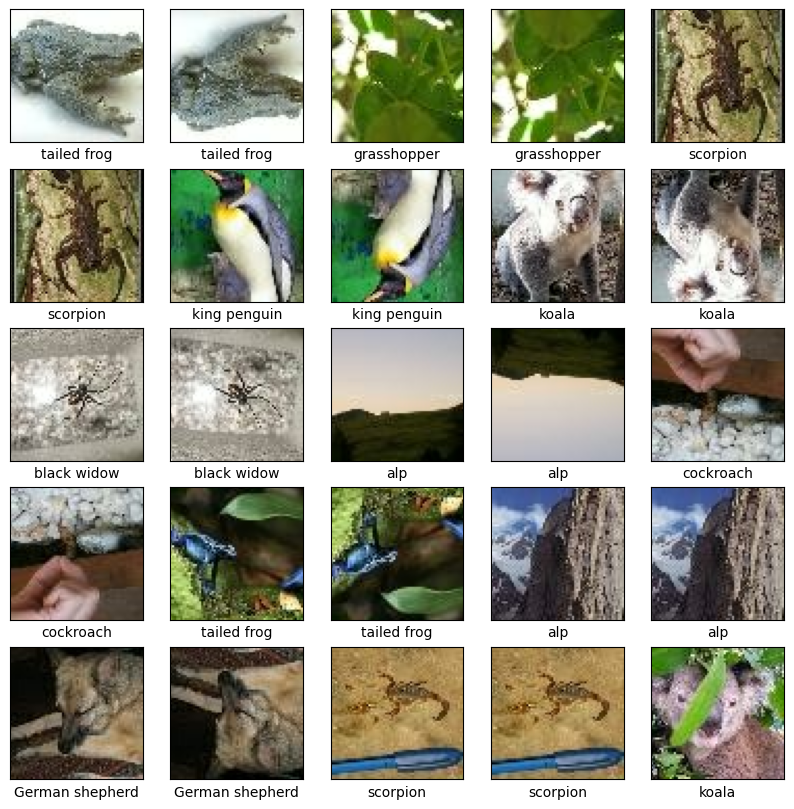

In [11]:
# Take one element from the dataset
sample = ds_train_aug.take(1)

plt.figure(figsize=(10,10))
# Iterate through the dataset and print images and label
for image, label in sample:
    # print( label)
    # Convert image tensor to NumPy array for visualization
    image_np = image.numpy()
    print("Image shape:", image_np.shape)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image_np[i])
        plt.xlabel(limited_classes[np.argmax(label[i])])
    plt.show()
    break

Image shape: (64, 64, 64, 3)


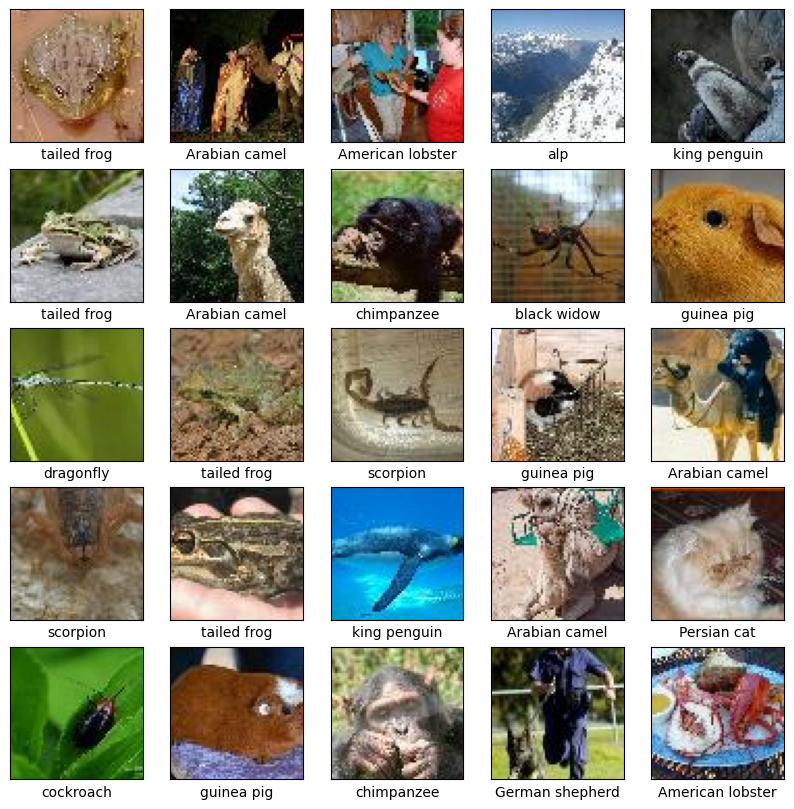

In [12]:
# Take one element from the dataset
sample = ds_valid.take(1)

plt.figure(figsize=(10,10))
# Iterate through the dataset and print images and label
for image, label in sample:
    # print( label)
    # Convert image tensor to NumPy array for visualization
    image_np = image.numpy()
    print("Image shape:", image_np.shape)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image_np[i])
        plt.xlabel(limited_classes[np.argmax(label[i])])
    plt.show()
    break



Image shape: (64, 64, 64, 3)


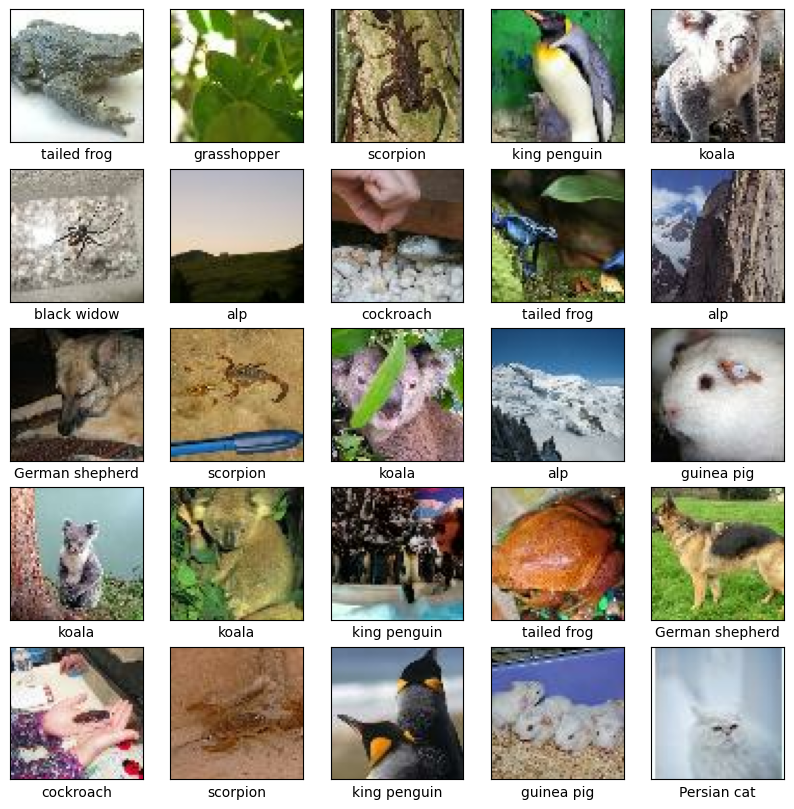

In [13]:
# Take one element from the dataset
sample = ds_train.take(1)

plt.figure(figsize=(10,10))
# Iterate through the dataset and print images and label
for image, label in sample:
    # Convert image tensor to NumPy array for visualization
    image_np = image.numpy()
    print("Image shape:", image_np.shape)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image_np[i])
        plt.xlabel(limited_classes[np.argmax(label[i])])

    plt.show()
    break



In [15]:
## plot functions 
def plot_hist_loss(hist):
    plt.plot(hist.history['loss'], label='Training Loss')
    plt.plot(hist.history['val_loss'], label='Validation Loss')
    plt.title("Training loss VS Validation loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()
    
def plot_hist(hist):
    plt.plot(hist.history["accuracy"], label='Training Accuracy')
    plt.plot(hist.history["val_accuracy"], label='Validation Accuracy')
    plt.title("Training Accuracy VS Validation Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()

def plot_hist_all(hist, hist1, hist2, hist3):
    plt.figure(figsize=(10, 6))
    plt.plot(hist.history['accuracy'], label='Train-WOR Loss')
    plt.plot(hist.history['val_accuracy'], label='Validation-WOR Loss')
    plt.plot(hist1.history["accuracy"], label='Train-L2 Loss')
    plt.plot(hist1.history["val_accuracy"], label='Validation-L2 Loss')
    plt.plot(hist2.history["accuracy"], label='Train-Dropout Loss')
    plt.plot(hist2.history["val_accuracy"], label='Validation-Dropout Loss')
    plt.plot(hist3.history["accuracy"], label='Train-Ensemble Loss')
    plt.plot(hist3.history["val_accuracy"], label='Validation-Ensemble Loss')
    plt.title("Training Accuracy VS Validation Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()
    
def plot_hist_all_loss(hist, hist1, hist2, hist3):
    plt.figure(figsize=(10, 6))
    plt.plot(hist.history['loss'], label='Train-WOR Loss')
    plt.plot(hist.history['val_loss'], label='Validation-WOR Loss')
    plt.plot(hist1.history["loss"], label='Train-L2 Loss')
    plt.plot(hist1.history["val_loss"], label='Validation-L2 Loss')
    plt.plot(hist2.history["loss"], label='Train-Dropout Loss')
    plt.plot(hist2.history["val_loss"], label='Validation-Dropout Loss')
    plt.plot(hist3.history["loss"], label='Train-Ensemble Loss')
    plt.plot(hist3.history["val_loss"], label='Validation-Ensemble Loss')
    plt.title("Training loss VS Validation loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()
    
def plot_hist_comp(hist, hist1, label1 , label2):
    plt.figure(figsize=(10, 6))
    plt.plot(hist.history['accuracy'], label='Train-WOR Accuracy', color="green")
    plt.plot(hist.history['val_accuracy'], label='Validation-WOR Accuracy', linestyle=':', color="green")
    plt.plot(hist1.history["accuracy"], label= label1, color="orange")
    plt.plot(hist1.history["val_accuracy"], label= label2, linestyle=':', color="orange")
    plt.title("Training Accuracy VS Validation Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()
    
def plot_hist_comp_loss(hist, hist1,label1 , label2 ):
    plt.figure(figsize=(10, 6))
    plt.plot(hist.history['loss'], label='Train-WOR Loss', color="green")
    plt.plot(hist.history['val_loss'], label='Validation-WOR Loss', linestyle=':', color="green")
    plt.plot(hist1.history["loss"], label= label1, color="orange")
    plt.plot(hist1.history["val_loss"], label= label2, linestyle=':', color="orange")
    plt.title("Training loss VS Validation loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()

# Model Definition, Training, and Evaluation

This markdown provides an explanation for defining a convolutional neural network (CNN) model architecture, training the model, and evaluating its performance.

## Model Architecture:

1. **Input Shape Definition**:
   - The input shape of the model is defined as `[None, IMG_SIZE, IMG_SIZE, 3]`, where `IMG_SIZE` represents the size of the input images and `3` represents the number of color channels (RGB).

2. **Model Layers**:
   - The model architecture consists of a series of convolutional and pooling layers followed by fully connected layers:
     - Convolutional layers: Conv2D layers with varying numbers of filters and kernel sizes, followed by ReLU activation and local response normalization.
     - Pooling layers: MaxPooling2D layers with specified pool size and strides.
     - Fully connected layers: Dense layers with ReLU activation.

3. **Compilation**:
   - The model is compiled with the Adam optimizer and categorical cross-entropy loss function for multiclass classification. Accuracy is used as a metric for evaluation.

4. **Model Summary**:
   - The summary of the model architecture is printed using `model.summary()`.

## Training and Evaluation:

1. **Training**:
   - The model is trained using the `fit` method with training data (`ds_train`) for a specified number of epochs (`EPOCHS`). Validation data (`ds_valid`) is provided for monitoring the model's performance during training.
   - A custom callback `LogMetricsCallback` is used to log training metrics (loss and accuracy) to a CSV file (`model.csv`) after each epoch.

2. **Evaluation**:
   - The trained model is evaluated using the validation dataset (`ds_valid`) to calculate the loss and accuracy on unseen data.

3. **Output**:
   - Test loss and accuracy are printed to evaluate the model's performance on the validation dataset.


In [14]:
# Define the input shape
input_shape = [None, IMG_SIZE, IMG_SIZE, 3]

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=(11, 11), strides=4, activation='relu', padding='same', input_shape=input_shape[1:]),
    tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=5, bias=2.0, alpha=1e-4, beta=0.75)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    tf.keras.layers.Conv2D(192, kernel_size=(5, 5), activation='relu', padding='same'),
    tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=5, bias=2.0, alpha=1e-4, beta=0.75)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    tf.keras.layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy'])

# Print the model summary
print(model.summary())

class LogMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, filename):
        super(LogMetricsCallback, self).__init__()
        self.filename = filename
        # Initialize the file with headers
        with open(self.filename, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy'])

    def on_epoch_end(self, epoch, logs=None):
        with open(self.filename, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([epoch, logs['loss'], logs['accuracy'], logs['val_loss'], logs['val_accuracy']])

output_file = "model.csv"
log_metrics_callback = LogMetricsCallback(output_file)
# Train the model
model_output = model.fit(
    ds_train, 
    epochs=EPOCHS, 
    validation_data=ds_valid, 
    batch_size=BATCH_SIZE,
    callbacks=[log_metrics_callback],
    )

# Evaluate the model
loss, accuracy = model.evaluate(ds_valid)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

/Users/hrishikesh/miniconda3/envs/MLCS_project/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 16, 16, 64)     │        23,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 192)      │       307,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 8, 8, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 384)      │       663,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │        15,375 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,321,679 (20.30 MB)

 Trainable params: 5,321,679 (20.30 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 21s 172ms/step - accuracy: 0.0656 - loss: 3.7641 - val_accuracy: 0.0668 - val_loss: 2.7102
Epoch 2/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 20s 171ms/step - accuracy: 0.0815 - loss: 2.7033 - val_accuracy: 0.0696 - val_loss: 2.7084
Epoch 3/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 20s 171ms/step - accuracy: 0.0640 - loss: 2.7013 - val_accuracy: 0.1463 - val_loss: 2.5536
Epoch 4/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 22s 190ms/step - accuracy: 0.1418 - loss: 2.5687 - val_accuracy: 0.1690 - val_loss: 2.5005
Epoch 5/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 23s 195ms/step - accuracy: 0.1769 - loss: 2.4726 - val_accuracy: 0.1989 - val_loss: 2.4286
Epoch 6/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 22s 184ms/step - accuracy: 0.2118 - loss: 2.3791 - val_accuracy: 0.2415 - val_loss: 2.3097
Epoch 7/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 21s 180ms/step - accuracy: 0.2516 - loss: 2.2792 - val_accuracy: 0.2500 - val_loss: 2.2777
Epoch 8/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 23s 195ms/step - accuracy: 0.2644 - lo

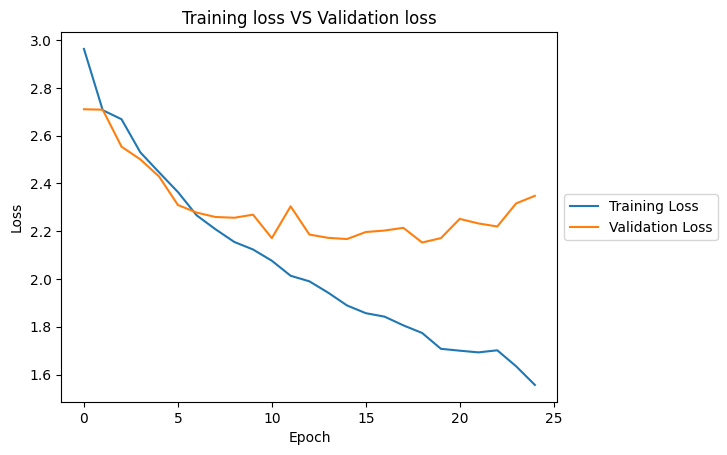

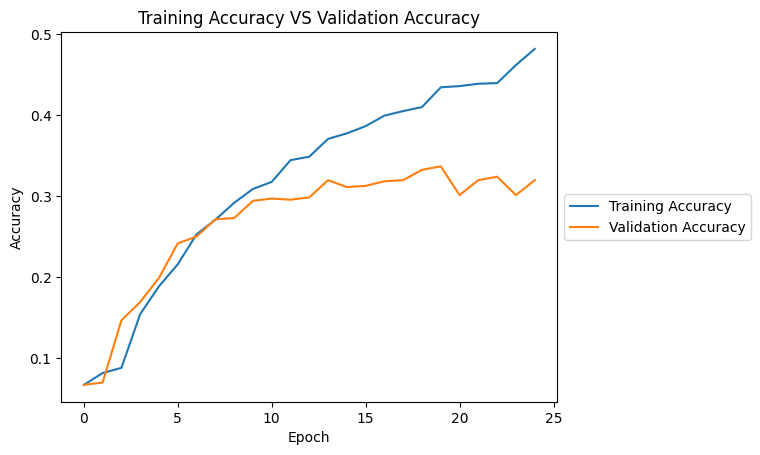

In [15]:
plot_hist_loss(model_output)
plot_hist(model_output)

# Model Definition with L2 Regularization, Training, and Evaluation

## Model Architecture with L2 Regularization:

1. **Input Shape Definition**:
   - The input shape of the model is defined as `[None, IMG_SIZE, IMG_SIZE, 3]`, similar to the previous model.

2. **Model Layers**:
   - The model architecture is similar to the previous one, with additional L2 regularization applied to the dense layers:
     - Convolutional layers: Conv2D layers with ReLU activation and local response normalization, followed by max-pooling.
     - Fully connected layers: Dense layers with ReLU activation and L2 regularization (with a regularization factor of `0.00002`).
     - The output layer uses the softmax activation function for multiclass classification.

3. **Compilation**:
   - The model is compiled with the Adam optimizer, categorical cross-entropy loss function, and accuracy metric, similar to the previous model.

4. **Model Summary**:
   - The summary of the model architecture with L2 regularization is printed using `model_l2.summary()`.

## Training and Evaluation:

1. **Training**:
   - The model is trained using the `fit` method with training data (`ds_train`) for a specified number of epochs (`EPOCHS`). Validation data (`ds_valid`) is provided for monitoring the model's performance during training.
   - A custom callback `LogMetricsCallback` is used to log training metrics (loss and accuracy) to a CSV file (`model_l2.csv`) after each epoch.

2. **Evaluation**:
   - The trained model is evaluated using the validation dataset (`ds_valid`) to calculate the loss and accuracy on unseen data.

3. **Output**:
   - Test loss and accuracy are printed to evaluate the model's performance on the validation dataset.

In [13]:
# Define the input shape
input_shape = [None, IMG_SIZE, IMG_SIZE, 3]

# Define the model architecture
model_l2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=(11, 11), strides=4, activation='relu', padding='same', input_shape=input_shape[1:]),
    tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=5, bias=2.0, alpha=1e-4, beta=0.75)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    tf.keras.layers.Conv2D(192, kernel_size=(5, 5), activation='relu', padding='same'),
    tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=5, bias=2.0, alpha=1e-4, beta=0.75)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    tf.keras.layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00002)),
    tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00002)),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
model_l2.compile(
    optimizer="adam", 
    loss="categorical_crossentropy",
    metrics=['accuracy'])

# Print the model summary
print(model_l2.summary())

class LogMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, filename):
        super(LogMetricsCallback, self).__init__()
        self.filename = filename
        # Initialize the file with headers
        with open(self.filename, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy'])

    def on_epoch_end(self, epoch, logs=None):
        with open(self.filename, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([epoch, logs['loss'], logs['accuracy'], logs['val_loss'], logs['val_accuracy']])

output_file = "model_l2.csv"
log_metrics_callback = LogMetricsCallback(output_file)
# Train the model
model_output_l2 = model_l2.fit(
    ds_train, 
    epochs=EPOCHS, 
    validation_data=ds_valid, 
    batch_size=BATCH_SIZE,
    callbacks = [log_metrics_callback]
    )

# Evaluate the model
loss, accuracy = model_l2.evaluate(ds_valid)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

/Users/hrishikesh/miniconda3/envs/NLP/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 16, 16, 64)     │        23,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 192)      │       307,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 8, 8, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 384)      │       663,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │        15,375 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,321,679 (20.30 MB)

 Trainable params: 5,321,679 (20.30 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 21s 174ms/step - accuracy: 0.0696 - loss: 4.4620 - val_accuracy: 0.0653 - val_loss: 2.7365
Epoch 2/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 20s 173ms/step - accuracy: 0.0617 - loss: 2.7367 - val_accuracy: 0.0653 - val_loss: 2.7346
Epoch 3/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 21s 177ms/step - accuracy: 0.0641 - loss: 2.7346 - val_accuracy: 0.0966 - val_loss: 2.7311
Epoch 4/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 21s 176ms/step - accuracy: 0.0851 - loss: 2.7098 - val_accuracy: 0.1307 - val_loss: 2.5700
Epoch 5/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 21s 183ms/step - accuracy: 0.1367 - loss: 2.5996 - val_accuracy: 0.1804 - val_loss: 2.5487
Epoch 6/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 22s 185ms/step - accuracy: 0.1738 - loss: 2.5235 - val_accuracy: 0.2003 - val_loss: 2.4727
Epoch 7/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 21s 178ms/step - accuracy: 0.1902 - loss: 2.4406 - val_accuracy: 0.2259 - val_loss: 2.4155
Epoch 8/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 21s 182ms/step - accuracy: 0.2312 - lo

# Loading History from CSV and Mocking History Objects

## Loading History from CSV:

1. **Function Definition**:
   - The function `load_history_from_csv` is defined to load training history data from a CSV file.
   - It reads the CSV file using Pandas and extracts the training and validation metrics (`loss` and `accuracy`) into a dictionary named `history`.

2. **Class Definition**:
   - The class `MockHistory` is defined to create mock history objects with the same structure as the loaded history dictionaries.
   - It takes the loaded history dictionary as input during initialization.

3. **Loading CSV Data**:
   - Training history data is loaded from CSV files for different models (`model.csv` and `model_l2.csv`).
   - The loaded history data is stored in variables `model_results` and `model_l2_results`.

4. **Mocking History Objects**:
   - The loaded history data is encapsulated within `MockHistory` objects to facilitate comparison and analysis.

## Output:

The process involves loading training history from CSV files and creating mock history objects, enabling easy comparison and analysis of training metrics for different models.



In [13]:
def load_history_from_csv(filename):
    df = pd.read_csv(filename)
    history = {
        "loss": df["train_loss"].tolist(),
        "accuracy": df["train_accuracy"].tolist(),
        "val_loss": df["val_loss"].tolist(),
        "val_accuracy": df["val_accuracy"].tolist()
    }
    return history
class MockHistory:
    def __init__(self, history):
        self.history = history
# Load the CSV data
model_results = load_history_from_csv("model.csv")
model_l2_results = load_history_from_csv("model_l2.csv")
model_results = MockHistory(model_results)
model_l2_results = MockHistory(model_l2_results)

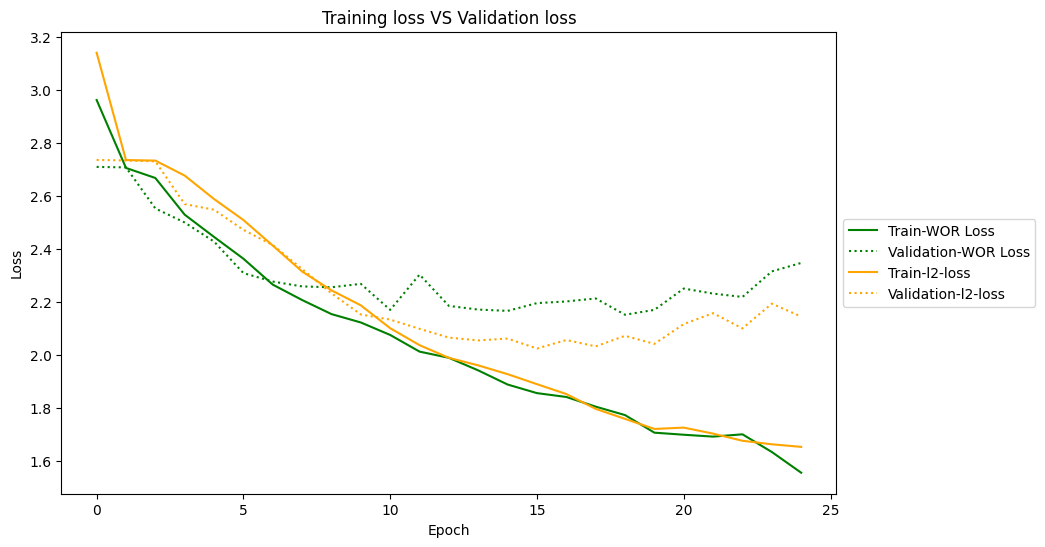

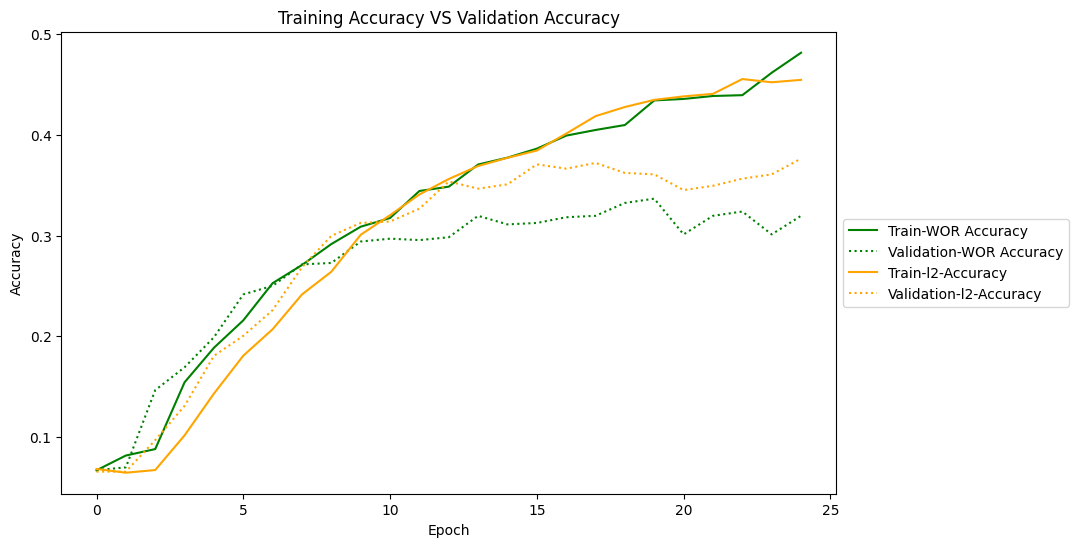

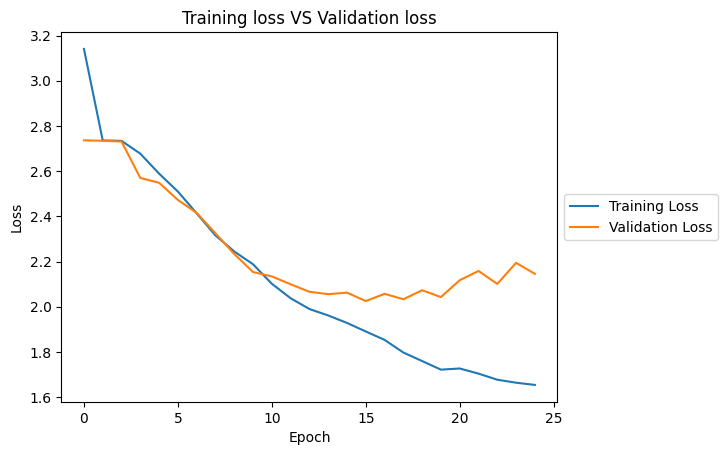

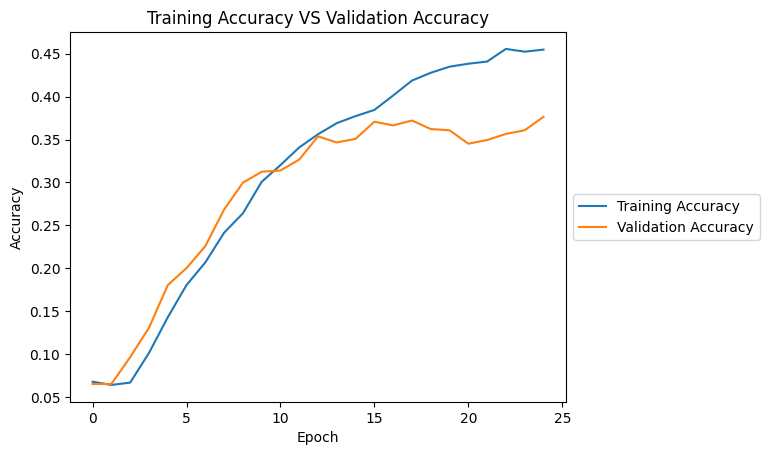

In [30]:
plot_hist_comp_loss(model_results , model_l2_results ,"Train-l2-loss" , "Validation-l2-loss")
plot_hist_comp(model_results , model_l2_results, "Train-l2-Accuracy" , "Validation-l2-Accuracy")
plot_hist_loss(model_output_l2)
plot_hist(model_output_l2)

In [31]:
# Define the input shape
input_shape = [None, IMG_SIZE, IMG_SIZE, 3]

# Define the model architecture
model_dropout = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=(11, 11), strides=4, activation='relu', padding='same', input_shape=input_shape[1:]),
    tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=5, bias=2.0, alpha=1e-4, beta=0.75)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    tf.keras.layers.Conv2D(192, kernel_size=(5, 5), activation='relu', padding='same'),
    tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=5, bias=2.0, alpha=1e-4, beta=0.75)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    tf.keras.layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model_dropout.compile(
    optimizer="adam",  
    loss="categorical_crossentropy",
    metrics=['accuracy'])

# Print the model summary
print(model_dropout.summary())

class LogMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, filename):
        super(LogMetricsCallback, self).__init__()
        self.filename = filename
        # Initialize the file with headers
        with open(self.filename, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy'])

    def on_epoch_end(self, epoch, logs=None):
        with open(self.filename, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([epoch, logs['loss'], logs['accuracy'], logs['val_loss'], logs['val_accuracy']])

output_file = "model_dropout.csv"
log_metrics_callback = LogMetricsCallback(output_file)
# Train the model
model_output_dropout = model_dropout.fit(
    ds_train, 
    epochs=EPOCHS, 
    validation_data=ds_valid, 
    batch_size=BATCH_SIZE,
    callbacks=[log_metrics_callback]
    )

# Evaluate the model
loss, accuracy = model_dropout.evaluate(ds_valid)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

/Users/hrishikesh/miniconda3/envs/NLP/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 64)     │        23,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 192)      │       307,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_3 (Lambda)               │ (None, 8, 8, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 384)      │       663,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 4, 4, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 4, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 15)             │        15,375 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,321,679 (20.30 MB)

 Trainable params: 5,321,679 (20.30 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 20s 165ms/step - accuracy: 0.0634 - loss: 3.4329 - val_accuracy: 0.0682 - val_loss: 2.7195
Epoch 2/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 18s 154ms/step - accuracy: 0.0836 - loss: 2.7023 - val_accuracy: 0.0653 - val_loss: 2.7087
Epoch 3/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 19s 163ms/step - accuracy: 0.0557 - loss: 2.7095 - val_accuracy: 0.0696 - val_loss: 2.7080
Epoch 4/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 19s 164ms/step - accuracy: 0.0674 - loss: 2.7080 - val_accuracy: 0.1222 - val_loss: 2.6254
Epoch 5/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 21s 183ms/step - accuracy: 0.1078 - loss: 2.6364 - val_accuracy: 0.1449 - val_loss: 2.5763
Epoch 6/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 22s 185ms/step - accuracy: 0.1478 - loss: 2.5446 - val_accuracy: 0.1733 - val_loss: 2.4850
Epoch 7/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 24s 208ms/step - accuracy: 0.1673 - loss: 2.5068 - val_accuracy: 0.1733 - val_loss: 2.4656
Epoch 8/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 28s 239ms/step - accuracy: 0.1766 - lo

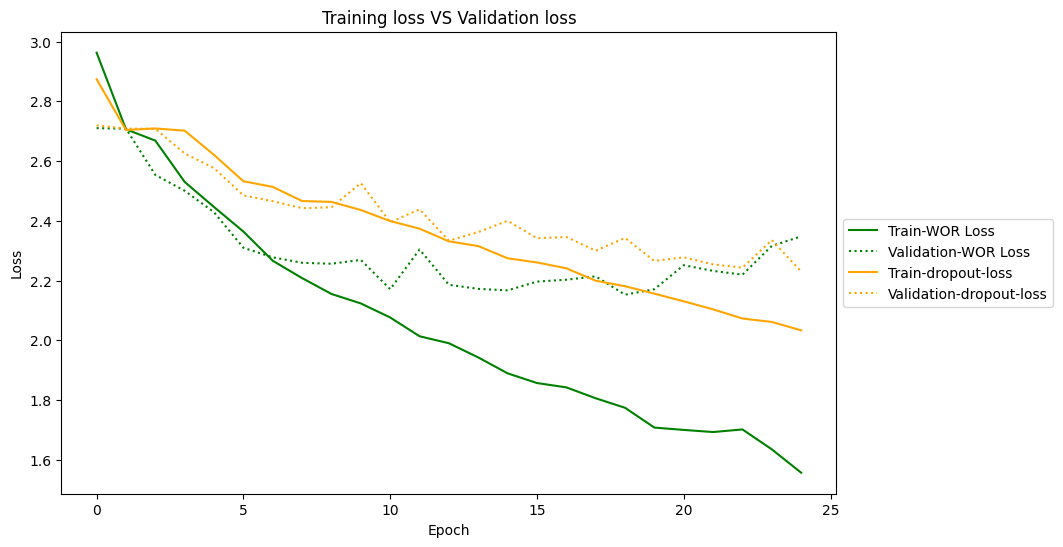

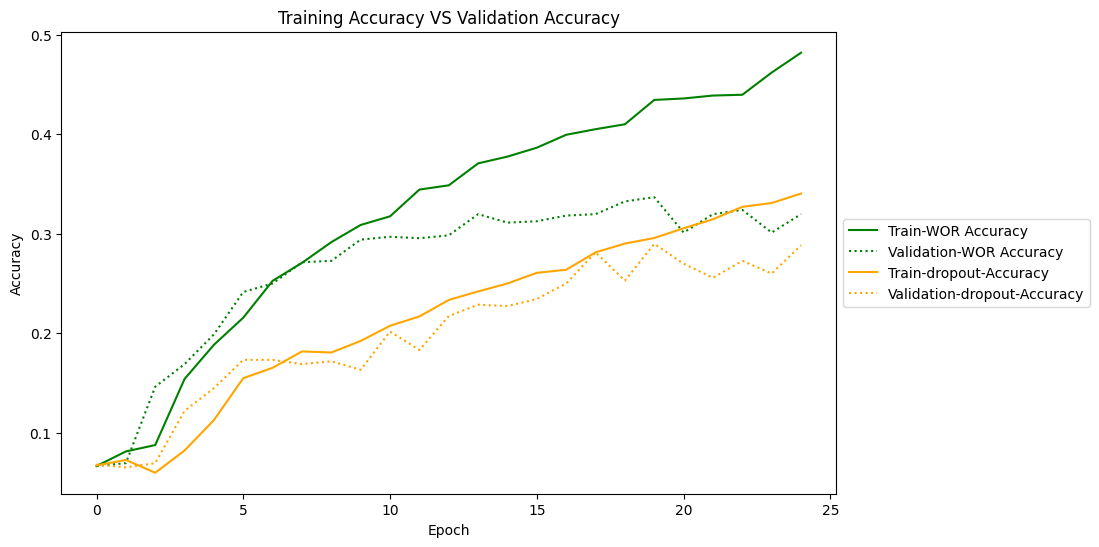

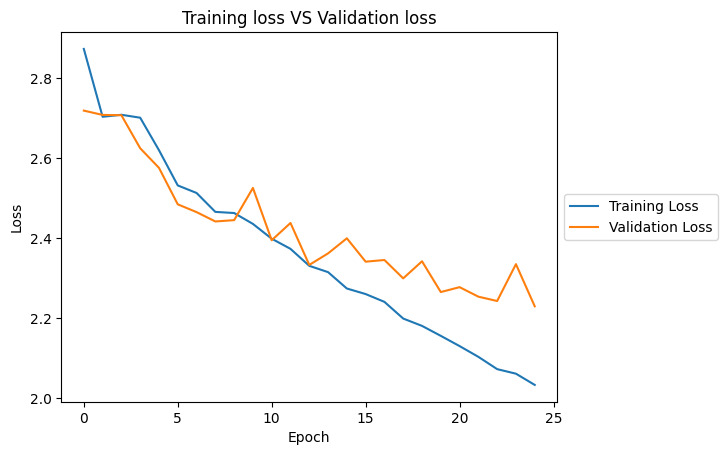

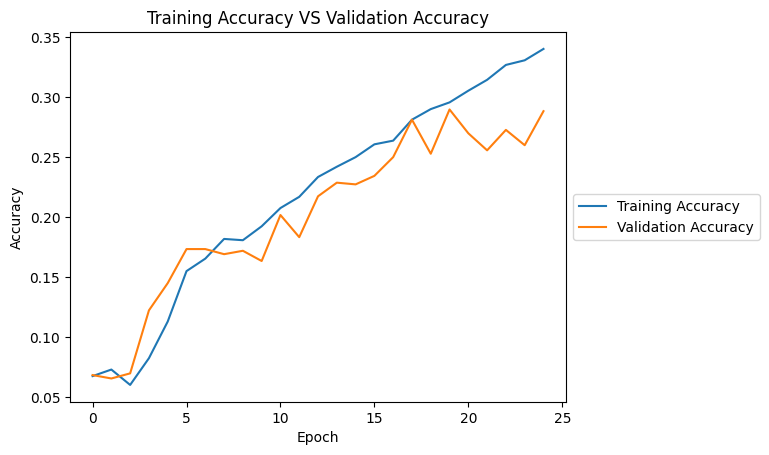

In [34]:
# Load the CSV data
model_results = load_history_from_csv("model.csv")
model_dropout_results = load_history_from_csv("model_dropout.csv")

model_results = MockHistory(model_results)
model_dropout_results = MockHistory(model_dropout_results)

plot_hist_comp_loss(model_results , model_dropout_results ,"Train-dropout-loss" , "Validation-dropout-loss")
plot_hist_comp(model_results , model_dropout_results, "Train-dropout-Accuracy" , "Validation-dropout-Accuracy")
plot_hist_loss(model_output_dropout)
plot_hist(model_output_dropout)

In [11]:
# Define the input shape
input_shape = [None, IMG_SIZE, IMG_SIZE, 3]

# Define the model architecture
model_ensemble = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=(11, 11), strides=4, activation='relu', padding='same', input_shape=input_shape[1:]),
    tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=5, bias=2.0, alpha=1e-4, beta=0.75)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    tf.keras.layers.Conv2D(192, kernel_size=(5, 5), activation='relu', padding='same'),
    tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=5, bias=2.0, alpha=1e-4, beta=0.75)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    tf.keras.layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00002)),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00002)),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
model_ensemble.compile(
    optimizer="adam", 
    loss="categorical_crossentropy",
    metrics=['accuracy'])

# Print the model summary
print(model_ensemble.summary())

class LogMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, filename):
        super(LogMetricsCallback, self).__init__()
        self.filename = filename
        # Initialize the file with headers
        with open(self.filename, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy'])

    def on_epoch_end(self, epoch, logs=None):
        with open(self.filename, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([epoch, logs['loss'], logs['accuracy'], logs['val_loss'], logs['val_accuracy']])

output_file = "model_ensemble.csv"
log_metrics_callback = LogMetricsCallback(output_file)
# Train the model
model_output_ensemble = model_ensemble.fit(
    ds_train, 
    epochs=EPOCHS, 
    validation_data=ds_valid, 
    batch_size=BATCH_SIZE,
    callbacks=[log_metrics_callback]
    )

# Evaluate the model
loss, accuracy = model_ensemble.evaluate(ds_valid)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

/Users/hrishikesh/miniconda3/envs/MLCS_project/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 16, 16, 64)     │        23,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 192)      │       307,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 8, 8, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 384)      │       663,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │        15,375 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,321,679 (20.30 MB)

 Trainable params: 5,321,679 (20.30 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 21s 171ms/step - accuracy: 0.0719 - loss: 3.3492 - val_accuracy: 0.0682 - val_loss: 2.7467
Epoch 2/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 19s 167ms/step - accuracy: 0.0757 - loss: 2.7294 - val_accuracy: 0.1506 - val_loss: 2.6231
Epoch 3/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 20s 169ms/step - accuracy: 0.1376 - loss: 2.6114 - val_accuracy: 0.1321 - val_loss: 2.5627
Epoch 4/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 20s 175ms/step - accuracy: 0.1699 - loss: 2.5019 - val_accuracy: 0.1463 - val_loss: 2.5664
Epoch 5/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 21s 178ms/step - accuracy: 0.2138 - loss: 2.4153 - val_accuracy: 0.2415 - val_loss: 2.3666
Epoch 6/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 21s 177ms/step - accuracy: 0.2510 - loss: 2.2998 - val_accuracy: 0.2330 - val_loss: 2.3636
Epoch 7/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 21s 181ms/step - accuracy: 0.2685 - loss: 2.2623 - val_accuracy: 0.2514 - val_loss: 2.3021
Epoch 8/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 22s 188ms/step - accuracy: 0.2862 - lo

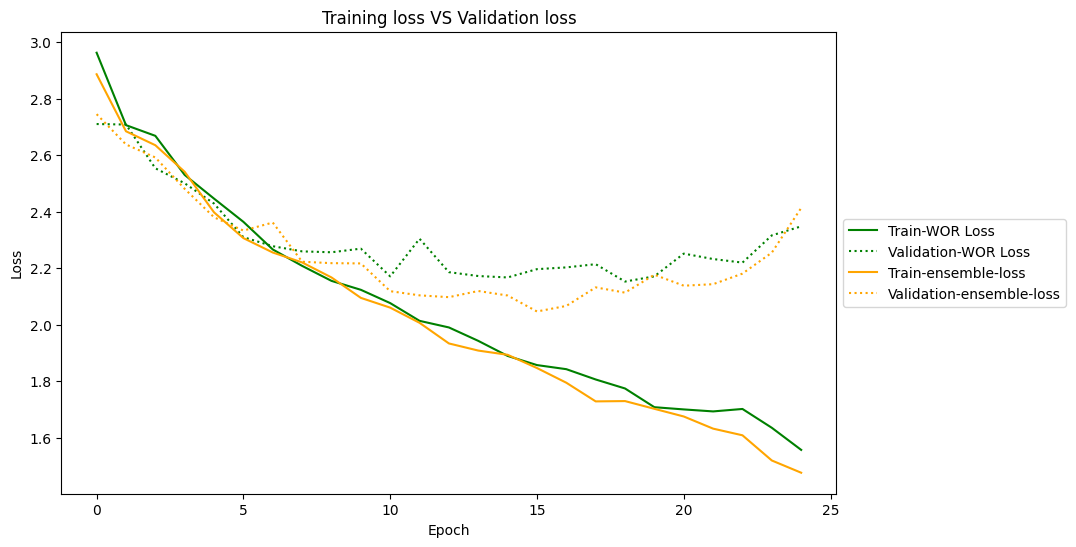

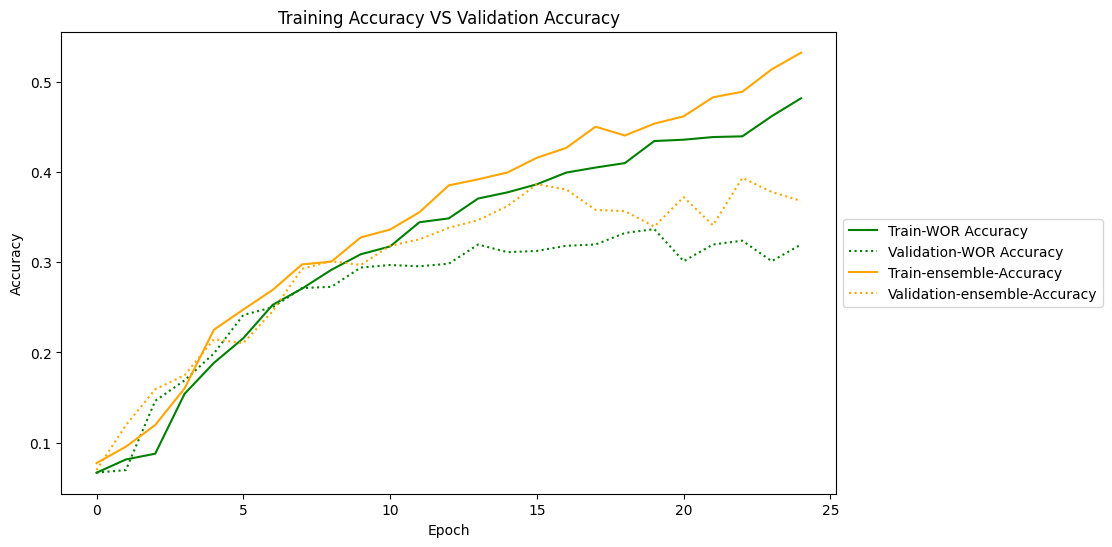

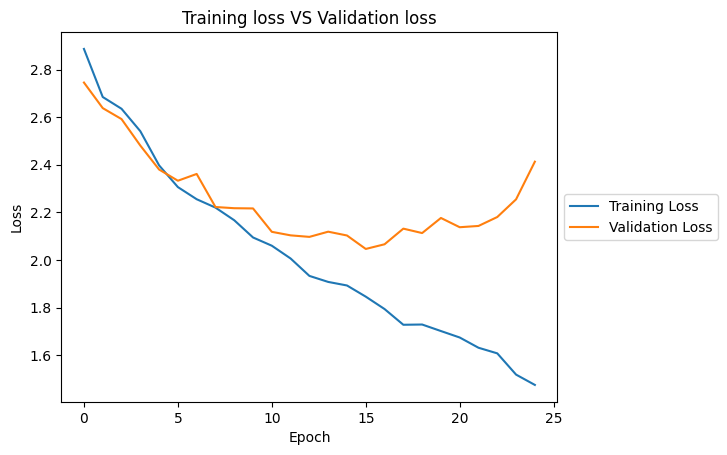

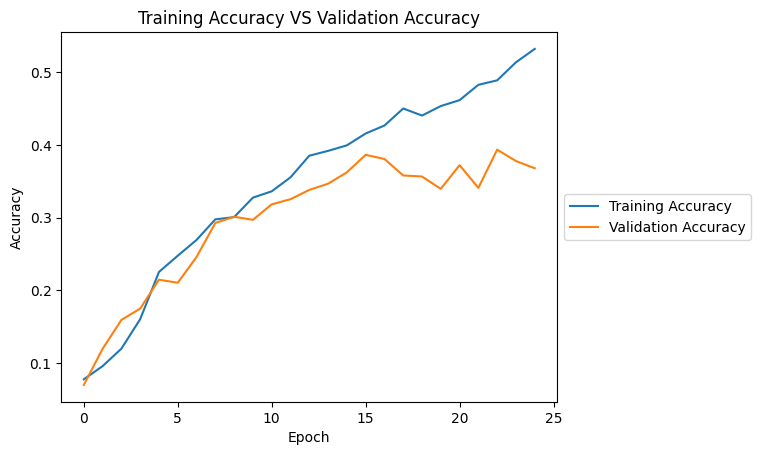

In [30]:
model_results = load_history_from_csv("model.csv")
model_ensemble_results = load_history_from_csv("model_ensemble.csv")
model_results = MockHistory(model_results)
model_ensemble_results = MockHistory(model_ensemble_results)
plot_hist_comp_loss(model_results , model_output_ensemble ,"Train-ensemble-loss" , "Validation-ensemble-loss")
plot_hist_comp(model_results , model_output_ensemble, "Train-ensemble-Accuracy" , "Validation-ensemble-Accuracy")
plot_hist_loss(model_output_ensemble)
plot_hist(model_output_ensemble)

In [ ]:
# Define the input shape
input_shape = [None, IMG_SIZE, IMG_SIZE, 3]

# Define the model architecture
model_aug = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=(11, 11), strides=4, activation='relu', padding='same', input_shape=input_shape[1:]),
    tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=5, bias=2.0, alpha=1e-4, beta=0.75)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    tf.keras.layers.Conv2D(192, kernel_size=(5, 5), activation='relu', padding='same'),
    tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=5, bias=2.0, alpha=1e-4, beta=0.75)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    tf.keras.layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
model_aug.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy'])

# Print the model summary
print(model_aug.summary())

class LogMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, filename):
        super(LogMetricsCallback, self).__init__()
        self.filename = filename
        # Initialize the file with headers
        with open(self.filename, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy'])

    def on_epoch_end(self, epoch, logs=None):
        with open(self.filename, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([epoch, logs['loss'], logs['accuracy'], logs['val_loss'], logs['val_accuracy']])

output_file = "model_aug.csv"
log_metrics_callback = LogMetricsCallback(output_file)
# Train the model
model_output_aug = model_aug.fit(
    ds_train_aug, 
    epochs=EPOCHS, 
    validation_data=ds_valid, 
    batch_size=BATCH_SIZE,
    callbacks=[log_metrics_callback],
    )

# Evaluate the model
loss, accuracy = model_aug.evaluate(ds_valid)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 64)     │        23,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 192)      │       307,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_3 (Lambda)               │ (None, 8, 8, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 384)      │       663,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 4, 4, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 4, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 15)             │        15,375 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,321,679 (20.30 MB)

 Trainable params: 5,321,679 (20.30 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/25
234/234 ━━━━━━━━━━━━━━━━━━━━ 34s 141ms/step - accuracy: 0.0787 - loss: 3.0225 - val_accuracy: 0.1463 - val_loss: 2.5723
Epoch 2/25
234/234 ━━━━━━━━━━━━━━━━━━━━ 34s 143ms/step - accuracy: 0.1435 - loss: 2.5535 - val_accuracy: 0.1534 - val_loss: 2.5839
Epoch 3/25
234/234 ━━━━━━━━━━━━━━━━━━━━ 34s 142ms/step - accuracy: 0.1910 - loss: 2.4508 - val_accuracy: 0.2159 - val_loss: 2.3840
Epoch 4/25
234/234 ━━━━━━━━━━━━━━━━━━━━ 34s 144ms/step - accuracy: 0.2370 - loss: 2.3208 - val_accuracy: 0.2656 - val_loss: 2.2796
Epoch 5/25
234/234 ━━━━━━━━━━━━━━━━━━━━ 34s 145ms/step - accuracy: 0.2563 - loss: 2.2456 - val_accuracy: 0.2898 - val_loss: 2.2035
Epoch 6/25
234/234 ━━━━━━━━━━━━━━━━━━━━ 34s 145ms/step - accuracy: 0.2853 - loss: 2.1662 - val_accuracy: 0.3111 - val_loss: 2.1185
Epoch 7/25
234/234 ━━━━━━━━━━━━━━━━━━━━ 34s 144ms/step - accuracy: 0.3113 - loss: 2.1019 - val_accuracy: 0.3182 - val_loss: 2.1031
Epoch 8/25
234/234 ━━━━━━━━━━━━━━━━━━━━ 32s 136ms/step - accuracy: 0.3316 - lo

In [ ]:
# Load the CSV data
model_results = load_history_from_csv("model.csv")
model_results = MockHistory(model_results)
model_results_aug = load_history_from_csv("model_aug.csv")
model_results_aug = MockHistory(model_results_aug)

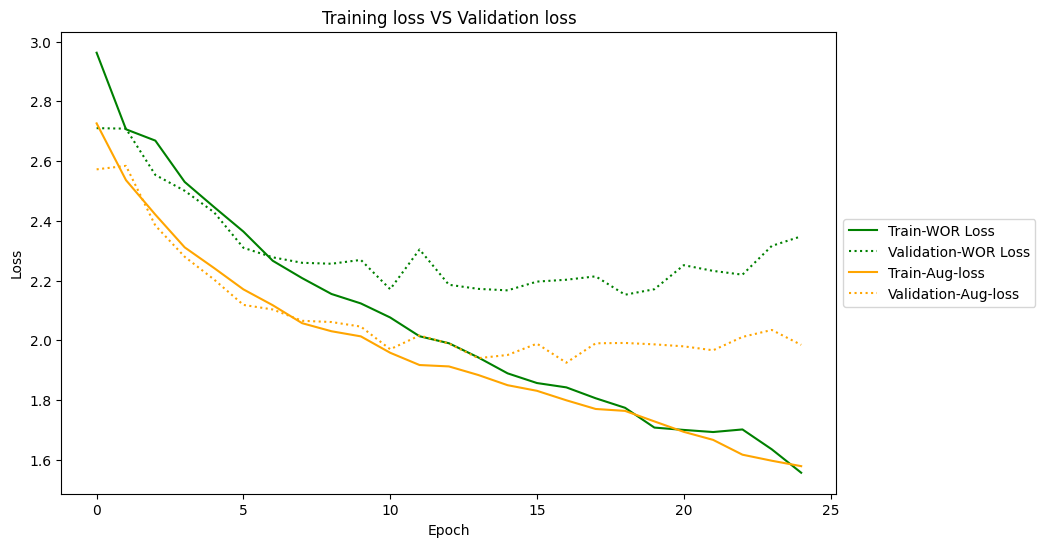

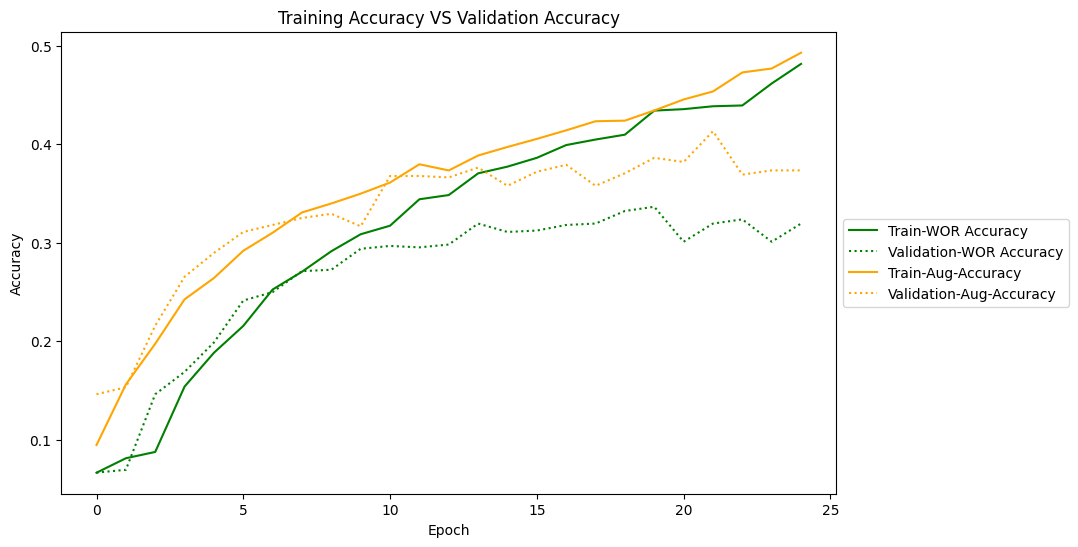

In [ ]:
plot_hist_comp_loss(model_results , model_results_aug ,"Train-Aug-loss" , "Validation-Aug-loss")
plot_hist_comp(model_results , model_results_aug, "Train-Aug-Accuracy" , "Validation-Aug-Accuracy")

# Regularization Techniques for Dataset 1

In [343]:
# 1. L2 Regularization - modifies the loss function. Applied to both datasets.
# 2. Data Augmentation - modifies the data. For Dataset1 we plan to use RandomErasing
#              - RandomErasing is concerned about removing and randomly adding information on the
#               blank space, such as noise. For Dataset2 we plan to use Random Synonym Replacement -
#               Random Synonym Replacement is concerned about removing and replacing with a synonym.
# 3. MaxDropout - modifies training approach. Applied to both datasets.
# 4. Ensemble Regularization 1 - applying RandomErasing and MaxDropout together. Applied to Dataset1.